In [1]:
import numpy
from time import time
from matplotlib import pyplot, cm
from matplotlib import rcParams
import matplotlib.patches as mpatches
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

# Tree Code vectorizado

Creación de clases

In [2]:
class Point():
    """The class for a point.
    
    Arguments:
        coords: a three-element list, containing the 3d coordinates of the point
        domain: the domain of random generated coordinates x,y,z, default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, coords=[], domain=1.0):
        if coords:
            assert len(coords) == 3, "the size of coords should be 3."
            self.x = coords[0]
            self.y = coords[1]
            self.z = coords[2]
        else:
            self.x = domain * numpy.random.random()
            self.y = domain * numpy.random.random()
            self.z = domain * numpy.random.random()
            
    # overload distance function
    def distance(self, other):
        return numpy.sqrt((self.x-other.x)**2 + (self.y-other.y)**2
                                          + (self.z-other.z)**2)

In [3]:
class Particle(Point):
    """The derived class for a particle, inheriting the base class "Point".
    
    Attributes:
        m: mass of the particle
        phi: the gravitational potential of the particle
    """
    
    def __init__(self, coords=[], domain=1.0, m=1.0):
        Point.__init__(self, coords, domain)
        self.m = m
        self.phi = 0.

In [4]:
class Cell():
    """The class for a cell.
    
    Arguments:
      n_crit: maximum number of particles in a leaf cell
    
    Attributes:
        nleaf (int): number of particles in the cell.
        leaf (array of int): array of leaves indices.
        nchild (int): 8-bit binary number, used to keep track of the empty child cells
        child (array of int): array of children indices.
        parent (int): index of parent cell.
        x, y, z (float): coordinates of the cell's center.
        r (float): radius of the cell (half of the length for cubic cell).
        multipole (array of float): array of multipoles' cell.
      
    """
    def __init__(self, n_crit):
        self.nleaf = 0        # number of particles
        self.leaf = numpy.zeros(n_crit, dtype=numpy.int)     # array of leaf index
        self.nchild = 0       # binary counter to keep track of empty cells
        self.child = numpy.zeros(8, dtype=numpy.int)         # array of child index
        self.parent = 0       # index of parent cell
        self.x = self.y = self.z = 0.                    # center of the cell
        self.r = 0.           # radius of the cell
        self.multipole = numpy.zeros(10, dtype=numpy.float)  # multipole array
        
    def distance(self, other):
        return numpy.sqrt((self.x-other.x)**2 + (self.y-other.y)**2
                                          + (self.z-other.z)**2)

In [ ]:
def direct_sum(particles):
    
    """Calculate the gravitational potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles.
    """
    
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m/r

# Creación del Árbol

Creaciación de la celda raíz

In [ ]:
n = 100          # number of particles
particles = [ Particle(m=1.0/n) for i in range(n) ]

n_crit = 10      # max number of particles in a single cell

In [ ]:
root = Cell(n_crit)
root.x, root.y, root.z = 0.5, 0.5, 0.5
root.r = 0.5

se define la función $\texttt{add_child}$ que crea una celda hija de $\texttt{p}$ en el octante $\texttt{octant}$ al final de la lista de celdas y la vincula a ella

In [5]:
def add_child(octant, p, cells, n_crit):
    """Add a cell to the end of cells list as a child of p,
       initialize the center and radius of the child cell c, 
       and establish mutual reference between child c and parent p.
    
    Arguments:
        octant: reference to the corresponding octant in 3D structure.
        p: is the index (in the cells list) of the corresponding parent.
        cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.
 
    """
    # create a new cell instance and append it to cells list
    cells.append(Cell(n_crit))
    # the last element of the cells list is the new child c
    c = len(cells) - 1
    # geometric relationship between parent and child
    cells[c].r = cells[p].r / 2
    cells[c].x = cells[p].x + cells[c].r * ((octant & 1) * 2 - 1)
    cells[c].y = cells[p].y + cells[c].r * ((octant & 2) - 1    )
    cells[c].z = cells[p].z + cells[c].r * ((octant & 4) / 2 - 1)
    # establish mutual reference in the cells list
    cells[c].parent = p
    cells[p].child[octant] = c
    cells[p].nchild = (cells[p].nchild | (1 << octant))
    print('+++cell {} is created as a child of cell {}'.format(c, p))

In [8]:
def split_cell(particles, p, cells, n_crit):
    """Loop in parent p's leaves and reallocate the particles to subcells. 
    If a subcell has not been created in that octant, it creates one using
    add_child. If the subcell nleaf exceeds n_crit, split the
    subcell c recursively.
    
    Arguments: 
        particles: the list of particles.
        p: is the index (in the cells list) of the corresponding parent.
        cells: the list of cells.
        n_crit: maximum number of particles in a leaf cell.
    
    """
    print('======start the split of cell {}======'.format(p))
    # loop over the particles in the parent cell that you want to split
    for l in cells[p].leaf:
        octant = (particles[l].x > cells[p].x) + ((particles[l].y > cells[p].y) << 1) \
               + ((particles[l].z > cells[p].z) << 2)   # finding the particle's octant
        # if there is not a child cell in the particle's octant, then create one
        if not cells[p].nchild & (1 << octant):
            add_child(octant, p, cells, n_crit)
        # reallocate the particle in the child cell
        c = cells[p].child[octant]
        cells[c].leaf[cells[c].nleaf] = l 
        cells[c].nleaf += 1
        print('>>>particle {} is reallocated in cell {}'.format(l, c))
        # check if the child reach n_crit
        if cells[c].nleaf >= n_crit:
            split_cell(particles, c, cells, n_crit)
    print('======end split cell {}======'.format(p))

In [7]:
def build_tree(particles, root, n_crit):
    """Construct a hierarchical octree to store the particles and
       return the tree (list) of cells.
    
    Arguments:
        particles: the list of particles.
        root: the root cell.
        n_crit: maximum number of leaves in a single cell.
    
    Returns:
        cells: the list of cells
    
    """
    # set root cell
    cells = [root]       # initialize the cells list

    # build tree
    n = len(particles)
    for i in range(n):
        # traverse from the root down to a leaf cell
        curr = 0
        while cells[curr].nleaf >= n_crit:
            cells[curr].nleaf += 1
            octant = (particles[i].x > cells[curr].x) + ((particles[i].y > cells[curr].y) << 1) \
                   + ((particles[i].z > cells[curr].z) << 2)
            # if there is no child cell in the particles octant, then create one
            if not cells[curr].nchild & (1 << octant):
                add_child(octant, curr, cells, n_crit)
            curr = cells[curr].child[octant]
        # allocate the particle in the leaf cell
        cells[curr].leaf[cells[curr].nleaf] = i
        cells[curr].nleaf += 1
        print('particle {} is stored in cell {}'.format(i, curr))
        # check whether to split or not
        if cells[curr].nleaf >= n_crit:
            split_cell(particles, curr, cells, n_crit)
    
    return cells

In [ ]:
cells = build_tree(particles, root, n_crit)

# Cálculo de multipolos

se define $\texttt{get_multipole}$ que calcula los multipolos de las celdas de los últimos niveles, es decir, el $\texttt{P2M}$

In [9]:
def get_multipole(particles, p, cells, n_crit):
    """Calculate multipole arrays for all leaf cells under cell p.
    If leaf number of cell p is equal or bigger than n_crit (non-leaf),
    traverse down recursively. Otherwise (leaf), calculate the multipole
    arrays for leaf cell p.
    
    Arguments:
        p: current cell's index
        cells: the list of cells
        particles: the array of all particles
        n_crit: maximum number of leaves in a single cell
      
    """
    # if the current cell p is not a leaf cell, then recursively traverse down
    if cells[p].nleaf >= n_crit:
        for c in range(8):
            if cells[p].nchild & (1 << c):
                get_multipole(particles, cells[p].child[c], cells, n_crit)
    # otherwise cell p is a leaf cell
    else:
        # loop in leaf particles, do P2M
        for i in range(cells[p].nleaf):
            l = cells[p].leaf[i]
            dx, dy, dz = cells[p].x-particles[l].x, \
                         cells[p].y-particles[l].y, \
                         cells[p].z-particles[l].z
            cells[p].multipole += particles[l].m * \
                                  numpy.array((1, dx, dy, dz,\
                                               dx**2/2, dy**2/2, dz**2/2,\
                                               dx*dy/2, dy*dz/2, dz*dx/2)) 

In [ ]:
get_multipole(particles, 0, cells, n_crit)

se define la función $\texttt{M2M}$ para calcular la contribución al multipolo de la celda padre $p$ de una celda hija $c$ y añadirla a su multipolo total

In [10]:
def M2M(p, c, cells):
    """Calculate parent cell p's multipole array based on child cell c's 
    multipoles
    
    Arguments:
        p: parent cell index in cells list
        c: child cell index in cells list
        cells: the list of cells
    """
    dx, dy, dz = cells[p].x-cells[c].x, cells[p].y-cells[c].y, cells[p].z-cells[c].z
    
    Dxyz =  numpy.array((dx, dy, dz))
    Dyzx = numpy.roll(Dxyz,-1) #It permutes the array (dx,dy,dz) to (dy,dz,dx) 
    
    cells[p].multipole += cells[c].multipole
    
    cells[p].multipole[1:4] += cells[c].multipole[0] * Dxyz
    
    cells[p].multipole[4:7] += cells[c].multipole[1:4] * Dxyz\
                             + 0.5*cells[c].multipole[0] *  Dxyz**2
    
    cells[p].multipole[7:] += 0.5*numpy.roll(cells[c].multipole[1:4], -1) * Dxyz \
                            + 0.5*cells[c].multipole[1:4] * Dxyz \
                            + 0.5*cells[c].multipole[0] * Dxyz * Dyzx   

la siguiente función recorre la lista de celdas desde el final hasta el comienzo, subiendo la información de multipolos a su celda padre

In [11]:
def upward_sweep(cells):
    """Traverse from leaves to root, in order to calculate multipoles
    of all the cells.
    
    Arguments:
        cells: the list of cells
    
    """
    for c in range(len(cells)-1, 0, -1):
        p = cells[c].parent
        M2M(p, c, cells)

In [ ]:
upward_sweep(cells)

# Evaluación de potencial

Se define la siguiente función para recorrer el árbol y hacer la evaluación de potencial para una partícula $i$ particular, en la siguiente función, se hace el recorrido para todas las partículas

In [13]:
def evaluate(particles, p, i, cells, n_crit, theta):
   
    """ Evaluate the gravitational potential at a target point i, 
    caused by source particles cell p. If nleaf of cell p is less 
    than n_crit (leaf), use direct summation. Otherwise (non-leaf), loop
    in p's child cells. If child cell c is in far-field of target particle i,
    use multipole expansion. Otherwise (near-field), call the function
    recursively.
    
    Arguments:
        particles: the list of particles
        p: cell index in cells list
        i: target particle index
        cells: the list of cells
        n_crit: maximum number of leaves in a single cell
        theta: tolerance parameter    
    """
    
    # non-leaf cell
    if cells[p].nleaf >= n_crit:
        # loop in p's child cells (8 octants)
        for octant in range(8):
            if cells[p].nchild & (1 << octant):
                c = cells[p].child[octant]
                r = particles[i].distance(cells[c])
                # near-field child cell
                if cells[c].r > theta*r: 
                    evaluate(particles, c, i, cells, n_crit, theta)
                # far-field child cell
                else:
                    dx = particles[i].x - cells[c].x
                    dy = particles[i].y - cells[c].y
                    dz = particles[i].z - cells[c].z
                    r3 = r**3
                    r5 = r3*r**2
                    # calculate the weight for each multipole
                    weight = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
                              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
                              3*dy*dz/r5, 3*dz*dx/r5]
                    particles[i].phi += numpy.dot(cells[c].multipole, weight)
                
    # leaf cell
    else:
        # loop in leaf cell's particles
        for l in range(cells[p].nleaf):
            source = particles[cells[p].leaf[l]]
            r = particles[i].distance(source)
            if r != 0:
                particles[i].phi += source.m / r

In [14]:
def eval_potential(particles, cells, n_crit, theta):
    
    """Evaluate the gravitational potential at all target points 
    
    Arguments:
    ----------
        particles: the list of particles.
        cells: the list of cells.
        n_crit: maximum number of particles in a single cell
        theta: tolerance parameter.    
    """
    
    for i in range(len(particles)):
        evaluate(particles, 0, i, cells, n_crit, theta)

In [ ]:
eval_potential(particles, cells, n_crit, 0.5)

# Vectorización

Supuesto: Los targets en el mismo twig interactúan de la misma forma con las cajas y partículas circundantes, por lo tanto, comparten lista de interacción.

In [ ]:
twigs = [cell for cell in cells if not cell.nleaf >= n_crit]

In [15]:
def interaction_list(particles, p, i, cells, n_crit, theta, lst, no_lst):
        # non-leaf cell
        if cells[p].nleaf >= n_crit:
            for octant in range(8):
                if cells[p].nchild & (1 << octant):
                    c = cells[p].child[octant]
                    r = twigs[i].distance(cells[c])
                    # near-field child cell
                    if cells[c].r > theta*r:
                        interaction_list(particles, c, i, cells, n_crit, theta, lst, no_lst)
                    # far-field child cell
                    else:
                        lst[len(lst) - 1].append(c)
        # leaf cell
        else:
            # loop in leaf cell's particles
            no_lst[len(no_lst) - 1].append(p)
            
def interaction_list_complete(particles, p, twigs, cells, n_crit, theta):
    lst = []
    no_lst = []
    for i in range(len(twigs)):
        lst.append([])
        no_lst.append([])
        interaction_list(particles, p, i, cells, n_crit, theta, lst, no_lst)
    return lst, no_lst


In [16]:
def eval_vec(twigs, lst, no_lst, particles, cells):
    for i, twig in enumerate(twigs):
        for j in range(twig.nleaf):
            # multipolo
            dx = particles[twig.leaf[j]].x - numpy.array([cells[k].x for k in lst[i]])
            dy = particles[twig.leaf[j]].y - numpy.array([cells[k].y for k in lst[i]])
            dz = particles[twig.leaf[j]].z - numpy.array([cells[k].z for k in lst[i]])
            r = numpy.sqrt(dx**2 + dy**2 + dz**2)
            r3 = r**3
            r5 = r3*r**2
            # calculate the weight for each multipole
            weight = numpy.array([1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
                              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
                              3*dy*dz/r5, 3*dz*dx/r5])
            multipole = numpy.array([cells[k].multipole for k in lst[i]])
            particles[twig.leaf[j]].phi += sum(sum(weight*numpy.transpose(multipole)))
            # direct sumation
            for k in no_lst[i]:
                for l in range(cells[k].nleaf):
                    source = particles[cells[k].leaf[l]]
                    r = particles[twig.leaf[j]].distance(source)
                    if r != 0.0:
                        particles[twig.leaf[j]].phi += source.m / r

# Comparación

## Tiempo

Creación del árbol y cálculo de los multipolos

In [ ]:
n = 100         # number of particles
particles = [ Particle(m = 1.0/n) for i in range(n) ]

n_crit = 10      # max number of particles in a single cell

root = Cell(n_crit)
root.x, root.y, root.z = 0.5, 0.5, 0.5
root.r = 0.5

tic = time()
cells = build_tree(particles, root, n_crit)
get_multipole(particles, 0, cells, n_crit)
upward_sweep(cells)
t_tree = time() - tic

## Vectorizado

In [19]:
tic = time()

twigs = [cell for cell in cells if not cell.nleaf >= n_crit]
lst, no_lst = interaction_list_complete(particles, 0, twigs, cells, n_crit, 0.5)
eval_vec(twigs, lst, no_lst, particles, cells)

t_vec = time() - tic

sol_vec = numpy.array([i.phi for i in particles])

print('El tree code vectorizado tardó ' + str(t_vec + t_tree) + '[s].')

El tree code vectorizado tardó 0.11509299278259277[s].


#### Normal
Limpiamos los potenciales

In [20]:
for i in particles:
    i.phi = 0.0

In [21]:
tic = time()

eval_potential(particles, cells, n_crit, 0.5)

t_nor = time() - tic

sol = numpy.array([i.phi for i in particles])

print('El tree code tardó ' + str(t_nor + t_tree) + '[s].')

El tree code tardó 0.4395449161529541[s].


## Error

In [22]:
err = numpy.sqrt(sum((sol-sol_vec)**2)/sum(sol**2))
print('L2 Norm error: {}%'.format(err*100))

L2 Norm error: 0.8822008575024501%


# Gráficos comparativos

In [ ]:
malla = numpy.array([100, 500, 1000, 5000]) #, 5000, 10000, 50000])
tnormal = []
tvectorizado = []
tds = []
tarbol = []
error_nordir = []
error_vecdir = []


for n in malla:
    particles = [ Particle(m = 1.0/n) for i in range(n) ]
    
    tic = time()
    direct_sum(particles)
    toc = time()

    tds.append(toc - tic)
    
    soldir = numpy.array([i.phi for i in particles])
    
    for i in particles:
        i.phi = 0.0

    n_crit = 10      # max number of particles in a single cell

    root = Cell(n_crit)
    root.x, root.y, root.z = 0.5, 0.5, 0.5
    root.r = 0.5

    tic = time()
    cells = build_tree(particles, root, n_crit)
    get_multipole(particles, 0, cells, n_crit)
    upward_sweep(cells)
    t_tree = time() - tic
    tarbol.append(t_tree)

    tic = time()

    twigs = [cell for cell in cells if not cell.nleaf >= n_crit]
    lst, no_lst = interaction_list_complete(particles, 0, twigs, cells, n_crit, 0.5)
    eval_vec(twigs, lst, no_lst, particles, cells)

    t_vec = time() - tic

    sol_vec = numpy.array([i.phi for i in particles])

    tvectorizado.append(t_vec + t_tree)

    for i in particles:
        i.phi = 0.0
    
    tic = time()

    eval_potential(particles, cells, n_crit, 0.5)

    t_nor = time() - tic

    sol = numpy.array([i.phi for i in particles])

    tnormal.append(t_nor + t_tree)

    error_vecdir.append(numpy.sqrt(sum((soldir-sol_vec)**2)/sum(soldir**2)))
    error_nordir.append(numpy.sqrt(sum((soldir-sol)**2)/sum(soldir**2)))

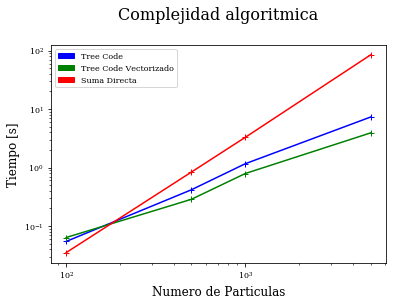

In [23]:
pyplot.plot(malla, tnormal, 'b-+')
pyplot.plot(malla, tvectorizado, 'g-+')
pyplot.plot(malla, tds, 'r-+')
pyplot.xlabel('Numero de Particulas', fontsize = 12)
pyplot.ylabel('Tiempo [s]', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Complejidad algoritmica\n', fontsize = 16)
blue = mpatches.Patch(color='blue', label='Tree Code')
green = mpatches.Patch(color='green', label='Tree Code Vectorizado')
red = mpatches.Patch(color ='red', label='Suma Directa')
pyplot.legend(handles=[blue, green, red])
pyplot.show()

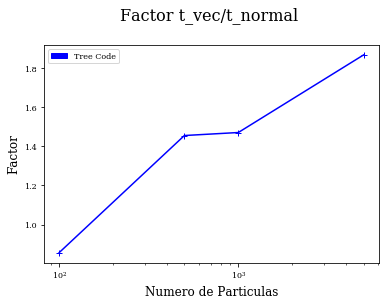

In [24]:
pyplot.plot(malla, numpy.array(tnormal)/numpy.array(tvectorizado), 'b-+')
pyplot.xlabel('Numero de Particulas', fontsize = 12)
pyplot.ylabel('Factor', fontsize = 12)
pyplot.xscale('log')
pyplot.title('Factor t_vec/t_normal \n', fontsize = 16)
blue = mpatches.Patch(color='blue', label='Tree Code')
pyplot.legend(handles=[blue])
pyplot.show()

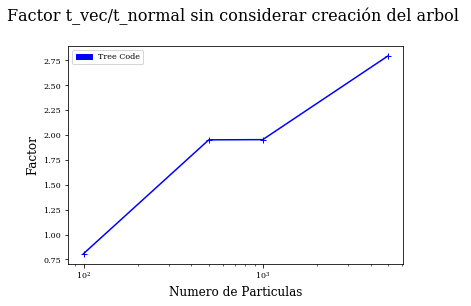

In [25]:
pyplot.plot(malla, (numpy.array(tnormal)-numpy.array(tarbol))/(numpy.array(tvectorizado)-numpy.array(tarbol)), 'b-+')
pyplot.xlabel('Numero de Particulas', fontsize = 12)
pyplot.ylabel('Factor', fontsize = 12)
pyplot.xscale('log')
pyplot.title('Factor t_vec/t_normal sin considerar creación del arbol \n', fontsize = 16)
blue = mpatches.Patch(color='blue', label='Tree Code')
pyplot.legend(handles=[blue])
pyplot.show()

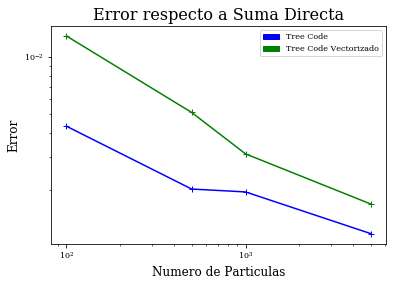

In [26]:
pyplot.plot(malla, error_nordir, 'b-+')
pyplot.plot(malla, error_vecdir, 'g-+')
pyplot.xlabel('Numero de Particulas', fontsize = 12)
pyplot.ylabel('Error', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Error respecto a Suma Directa', fontsize = 16)
blue = mpatches.Patch(color='blue', label='Tree Code')
green = mpatches.Patch(color='green', label='Tree Code Vectorizado')
pyplot.legend(handles=[blue, green])
pyplot.show()

In [ ]:
n = 2000
particles = [ Particle(m = 1.0/n) for i in range(n) ]
malla = numpy.array([int(n/1000), int(n/500), int(n/100), int(n/50), int(n/10)])
tnormal = []
tvectorizado = []
error = []

for n_crit in malla:
    for particle in particles:
        particle.phi = 0.0
    root = Cell(n_crit)
    root.x, root.y, root.z = 0.5, 0.5, 0.5
    root.r = 0.5

    tic = time()
    cells = build_tree(particles, root, n_crit)
    get_multipole(particles, 0, cells, n_crit)
    upward_sweep(cells)
    t_tree = time() - tic

    tic = time()

    twigs = [cell for cell in cells if not cell.nleaf >= n_crit]
    lst, no_lst = interaction_list_complete(particles, 0, twigs, cells, n_crit, 0.5)
    eval_vec(twigs, lst, no_lst, particles, cells)

    t_vec = time() - tic

    sol_vec = numpy.array([i.phi for i in particles])

    tvectorizado.append(t_vec + t_tree)

    for i in particles:
        i.phi = 0.0
    
    tic = time()

    eval_potential(particles, cells, n_crit, 0.5)

    t_nor = time() - tic

    sol = numpy.array([i.phi for i in particles])

    tnormal.append(t_nor + t_tree)

    error.append(numpy.sqrt(sum((sol-sol_vec)**2)/sum(sol**2)))

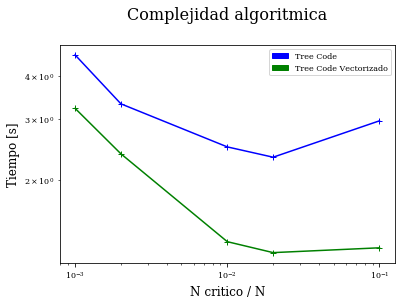

In [28]:
pyplot.plot(malla/n, tnormal, 'b-+')
pyplot.plot(malla/n, tvectorizado, 'g-+')
pyplot.xlabel('N critico / N', fontsize = 12)
pyplot.ylabel('Tiempo [s]', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Complejidad algoritmica\n', fontsize = 16)
blue = mpatches.Patch(color='blue', label='Tree Code')
green = mpatches.Patch(color='green', label='Tree Code Vectorizado')
pyplot.legend(handles=[blue, green])
pyplot.show()

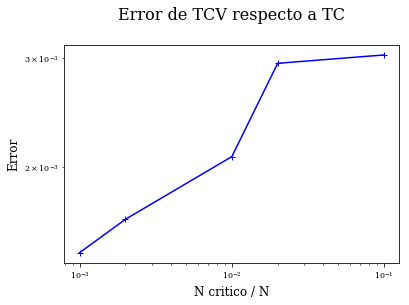

In [29]:
pyplot.plot(malla/n, error, 'b-+')
pyplot.xlabel('N critico / N', fontsize = 12)
pyplot.ylabel('Error', fontsize = 12)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Error de TCV respecto a TC\n', fontsize = 16)
pyplot.show()